In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from os import chdir
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.layers import Dropout

from sklearn.model_selection import train_test_split

import pickle
from IPython.display import clear_output

In [2]:
#планируется словарь алгоритмов для более быстрого создания всех датафреймов
alg_dict = {'sort': ['bubble_sort', 'quick_sort'], 'find': ['binary_search']}

In [3]:
#создание датафрейма
def make_df():
    df = pd.read_csv('csv\dataset.csv')
    df = df.set_index('filename')
    del df['Unnamed: 0']
    return df

In [4]:
def classification(df):
    lst_class = []
    for language,algorithm,algorithm_name in zip(df['language'],df['algorithm'],df['algorithm_name']):
        algorithm_name = algorithm_name.strip()
        if algorithm_name == 'bubble_sort':
            lst_class.append([1,0,0])
        elif algorithm_name == 'binary_search':
            lst_class.append([0,1,0])
        elif algorithm_name == 'quick_sort':
            lst_class.append([0,0,1])
    return df, lst_class

In [5]:
def classification_sort(df):
    cnt = 0
    df = df[df['algorithm'] == 'sort']
    sort_class = []
    for language,algorithm,algorithm_name in zip(df['language'],df['algorithm'],df['algorithm_name']):
        algorithm_name = algorithm_name.strip()
        if algorithm_name == 'bubble_sort':
            sort_class.append([1,0])
            cnt += 1
        if algorithm_name == 'quick_sort':
            sort_class.append([0,1])
    return df, sort_class, cnt

In [6]:
def classification_find(df):
    df = df[df['algorithm'] == 'find']
    find_class = []
    for language,algorithm,algorithm_name in zip(df['language'],df['algorithm'],df['algorithm_name']):
        algorithm_name = algorithm_name.strip()
        if algorithm_name == 'binary_search':
            find_class.append([1,0])
    return df, find_class

In [7]:
def file_read(df):
    new_lines = []
    #df = df.sort_values(by='filename')
    for index, row in df.iterrows():
        chdir(f'dataset/{row[1]}/{row[2]}')
        with open(str(index),'r', encoding = 'utf-8') as f:
            lines = f.readlines()
            lines = [line for line in lines if line.strip() != ""]
        %cd ../../..
        new_lines.append(lines)
    #%cd ../..
    return new_lines

In [8]:
#обработка переменной без табов, заменяя их на 2 пробела (Доработать)
def preporcessing_files(lines):
    new_lines = []
    code_line = ''
    for i in lines:
        for j in i:
            j = j.replace('    ', ' ')
            code_line += j
        new_lines.append(code_line)
    return new_lines

In [9]:
df = make_df()

In [10]:
# #общая классификация
# df, classes = classification(df)
# files = file_read(df)
# pre_files = preporcessing_files(files)
# clear_output()

In [10]:
#Для сортировки
df_sort, classes_sort,cnt = classification_sort(df)
files_sort = file_read(df_sort)
pre_files_sort = preporcessing_files(files_sort)
clear_output()

# Основная часть, построение архитектуры

In [11]:
maxWord = 1000
max_text_len = 50
tokenizer = Tokenizer(num_words=maxWord, lower = True, split = ' ', char_level=False)
tokenizer.fit_on_texts(pre_files_sort) #Меняем данные
dist = list(tokenizer.word_counts.items())
data = tokenizer.texts_to_sequences(pre_files_sort) #Меняем данные 
data_pad = pad_sequences(data,maxlen = max_text_len)

In [10]:
# with open('files\\data.pickle', 'wb') as file:
#     pickle.dump(data, file)

In [146]:
with open('files\\тест_модель_1.pickle', 'wb') as file:
    pickle.dump(pre_files_sort, file)

In [12]:
X = data_pad
Y = np.array(classes_sort)

In [13]:
len(data_pad)

824

In [14]:
len(data_pad) == len(X) == len(Y) == len(pre_files_sort)

True

In [22]:
model = Sequential([
    Embedding(maxWord, 64, input_length = max_text_len),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dense(2, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 64)            64000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 32)            12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 79,586
Trainable params: 79,586
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(loss ='binary_crossentropy', metrics = ['accuracy'], optimizer = Adam(0.0001))

In [33]:
train_data, val_data, train_class, val_class = train_test_split(X,Y, test_size=0.2)

In [34]:
history = model.fit(X,Y, batch_size = 32, epochs = 10)

Epoch 1/10
26/26 [==============================] - 2s 19ms/step - loss: 0.2391 - accuracy: 1.0000
Epoch 2/10
26/26 [==============================] - 0s 15ms/step - loss: 0.2143 - accuracy: 1.0000
Epoch 3/10
26/26 [==============================] - 0s 13ms/step - loss: 0.1964 - accuracy: 1.0000
Epoch 4/10
26/26 [==============================] - 0s 13ms/step - loss: 0.1801 - accuracy: 1.0000
Epoch 5/10
26/26 [==============================] - 0s 13ms/step - loss: 0.1655 - accuracy: 1.0000
Epoch 6/10
26/26 [==============================] - 0s 12ms/step - loss: 0.1517 - accuracy: 1.0000
Epoch 7/10
26/26 [==============================] - 0s 10ms/step - loss: 0.1392 - accuracy: 1.0000
Epoch 8/10
26/26 [==============================] - 0s 10ms/step - loss: 0.1278 - accuracy: 1.0000
Epoch 9/10
26/26 [==============================] - 0s 9ms/step - loss: 0.1179 - accuracy: 1.0000
Epoch 10/10
26/26 [==============================] - 0s 10ms/step - loss: 0.1103 - accuracy: 1.0000


In [117]:
history = model.fit(train_data,train_class, validation_data=(val_data,val_class), batch_size = 32, epochs = 10)

Epoch 1/10
21/21 [==============================] - 0s 18ms/step - loss: 5.3127e-05 - accuracy: 1.0000 - val_loss: 5.0147e-05 - val_accuracy: 1.0000
Epoch 2/10
21/21 [==============================] - 0s 10ms/step - loss: 5.0591e-05 - accuracy: 1.0000 - val_loss: 4.8020e-05 - val_accuracy: 1.0000
Epoch 3/10
21/21 [==============================] - 0s 10ms/step - loss: 4.8964e-05 - accuracy: 1.0000 - val_loss: 4.6057e-05 - val_accuracy: 1.0000
Epoch 4/10
21/21 [==============================] - 0s 10ms/step - loss: 4.7121e-05 - accuracy: 1.0000 - val_loss: 4.4215e-05 - val_accuracy: 1.0000
Epoch 5/10
21/21 [==============================] - 0s 10ms/step - loss: 4.4824e-05 - accuracy: 1.0000 - val_loss: 4.2450e-05 - val_accuracy: 1.0000
Epoch 6/10
21/21 [==============================] - 0s 9ms/step - loss: 4.3695e-05 - accuracy: 1.0000 - val_loss: 4.0860e-05 - val_accuracy: 1.0000
Epoch 7/10
21/21 [==============================] - 0s 10ms/step - loss: 4.1276e-05 - accuracy: 1.0000 - va

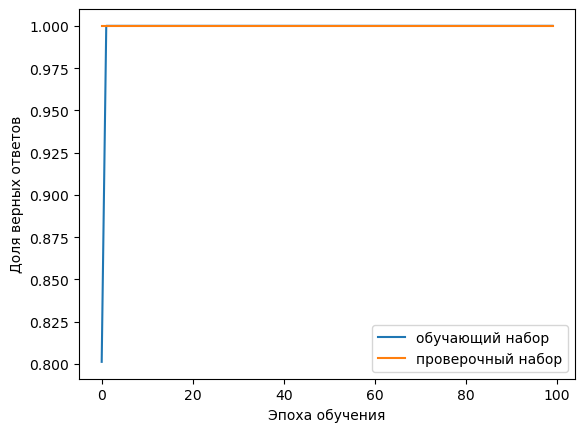

In [110]:
plt.plot(history.history['accuracy'],
         label='обучающий набор')
plt.plot(history.history['val_accuracy'],
         label='проверочный набор')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Тест моделей

In [36]:
# reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
# def seqence_to_text(list_of_indices):
#     return [reverse_word_map.get(letter) for letter in list_of_indices]

In [36]:
test_text = """
def bubble_sort(arr):
    n = len(arr)
    for i in range(n):
        for j in range(0, n - i - 1):
            if arr[j] > arr[j + 1]:
                arr[j], arr[j + 1] = arr[j + 1], arr[j]

# Пример использования:
arr = [3, 6, 8, 10, 1, 2, 1]
print("Исходный массив:", arr)
sorted_arr = bubble_sort(arr)
print("Отсортированный массив:", sorted_arr)
            """.lower()
data_test = tokenizer.texts_to_sequences([test_text])
data_pad_test = pad_sequences(data_test, maxlen = max_text_len)
res = model.predict(data_pad_test)
print(res, np.argmax(res))

[[0.9900546  0.00994533]] 0


In [44]:
test_text = """
def quicksort(arr):
    if len(arr) <= 1:
        return arr
    else:
        pivot = arr[0]
        less = [x for x in arr[1:] if x <= pivot]
        greater = [x for x in arr[1:] if x > pivot]
        return quicksort(less) + [pivot] + quicksort(greater)

# Пример использования:
arr = [3, 6, 8, 10, 1, 2, 1]
print("Исходный массив:", arr)
sorted_arr = quicksort(arr)
print("Отсортированный массив:", sorted_arr)
            """.lower()
data_test = tokenizer.texts_to_sequences([test_text])
data_pad_test = pad_sequences(data_test, maxlen = max_text_len)
res = model.predict(data_pad_test)
print(res, np.argmax(res))

[[0.01434759 0.98565245]] 1


In [35]:
model.save('models\\бинарная_кроссентропия.h5')

# Вспомогательные функции

In [12]:
pwd

'C:\\Users\\Matvey\\Анализ кода\\Code-Insight\\dataset'

In [22]:
%cd Анализ кода/Code-Insight

C:\Users\Matvey\Анализ кода\Code-Insight


In [82]:
%cd ../..

C:\Users\Matvey\Анализ кода\Code-Insight


In [ ]:
%cd ../

In [ ]:
%cd ../../..